**15_LAK__ii__SFR__MVR**

In [1]:
import os ; import pathlib as pl ; import pandas as pd; import flopy ; import matplotlib.pyplot as plt ; import numpy as np; from pathlib import Path  
from flopy.plot.styles import styles ; from modflow_devtools.misc import get_env, timed ; write=get_env("WRITE", True);run=get_env("RUN", True)
import shapefile as shp 

In [2]:
sim_ws         = Path("./15")                            ; sim_ws.mkdir(exist_ok=True) ; sim_name = "ex-gwf-lak-p02"
exe_name       = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = figs_path = sim_ws ; gwf_name = sim_name ; output_folder = sim_ws
path = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-lak-p02'                       
fpath1 = os.path.join(path ,'lakes-01.txt')              ; fpath2  = os.path.join(path,'lakes-02.txt')   

In [3]:
length_units = "feet" ; nper = 1 ;nlay = 5 ;nrow = 27 ;ncol = 17 ;top = 200 ;strt = 115 ;k11 = 30 ;k33 = 30 ;ss = 0.0003 ;sy = 0.2 
time_units = "days"   ; H1 = 160 ;H2 = 140 ;recharge = 0.0116 ;etvrate = 0.0141 ;etvdepth = 15 ;lak_strt = 130 ;lak_etrate = 0.0103 ;
lak_bedleak = 0.1     ; nouter = 500 ;ninner = 100 ;hclose = 0.000000001 ;rclose = 0.000001 
botm_str = "102., 97., 87., 77., 67."  ;
botm = [float(value) for value in botm_str.split(",")]  ; tdis_ds = ((1500.0, 200, 1.005),)

delr = np.array([250.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 500.0, 500.0, 500.0, 500.0, 500.00, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 250.0])
delc = np.array([250.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 500.0, 500.0, 500.0, 500.0, 500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 500.0, 
                 500.0, 500.0, 500.0, 500.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 250.0])

extents = (0.0, delr.sum(), 0.0, delc.sum())  ; shape2d = (nrow, ncol)  ; shape3d = (nlay, nrow, ncol)
lake_map = np.ones(shape3d,dtype=int)*-1   ; lake_map[0,:,:] = np.loadtxt(fpath1,dtype=int) - 1  ; lake_map[1,:,:] =np.loadtxt(fpath2,dtype=int)-1

xlen = delr.sum() - 0.5 * (delr[0] + delr[-1])    ; x = 0.0   ; s1d = H1 * np.ones(ncol, dtype=float)
for idx in range(1, ncol):
    x += 0.5 * (delr[idx - 1] + delr[idx])  ; frac = x / xlen                             ; s1d[idx] = H1 + (H2 - H1) * frac
surf = np.tile(s1d, (nrow, 1))              ; surf[lake_map[0, :, :] > -1] = botm[0] - 2  ; surf[lake_map[1, :, :] > -1] = botm[1] - 2

chd_spd = []
for k in range(nlay): chd_spd += [[k, i, 0, H1] for i in range(nrow)]   ; chd_spd += [[k, i, ncol - 1, H2] for i in range(nrow)]

lak_time_conv = 86400.0  ; lak_len_conv = 3.28081 
lak_outlets = [[0, 0, -1, "manning", 114.85, 5.0, 0.05, 8.206324419006205e-4],[1, 1, -1, "manning", 109.4286, 5.0, 0.05, 9.458197164349258e-4]]
lak_spd = [[0, "rainfall", recharge],[0, "evaporation", lak_etrate],[1, "rainfall", recharge],[1, "evaporation", lak_etrate]]

mvr_paks = [["SFR-1"],["LAK-1"]]
mvr_spd  = [["SFR-1", 7, "LAK-1", 0, "FACTOR", 1.0],["LAK-1", 0, "SFR-1", 8, "FACTOR", 1.0],
            ["SFR-1", 13, "LAK-1", 1, "FACTOR", 1.0],["LAK-1", 1, "SFR-1", 14, "FACTOR", 0.5]]

In [4]:
sfr_pakdata=[[0, 0, 1, 4, 1000, 5, 0.001103448, 123.94827, 0.5, 0.5, 0.050000001, 1, 1, 0], [1, 0, 2, 4, 1000, 5, 0.001103448, 122.84483, 0.5, 0.5, 0.050000001, 2, 1, 0], [2, 0, 3, 4, 1000, 5, 0.001103448, 121.74138, 0.5, 0.5, 0.050000001, 2, 1, 0], [3, 0, 3, 5, 1000, 5, 0.001103448, 120.63793, 0.5, 0.5, 0.050000001, 2, 1, 0], [4, 0, 3, 6, 500, 5, 0.001103448, 119.81035, 0.5, 0.5, 0.050000001, 2, 1, 0], [5, 0, 3, 7, 750, 5, 0.001103448, 119.12069, 0.5, 0.5, 0.050000001, 2, 1, 0], [6, 0, 4, 7, 1000, 5, 0.001103448, 118.15517, 0.5, 0.5, 0.050000001, 2, 1, 0], [7, 0, 5, 7, 1000, 5, 0.001103448, 117.05173, 0.5, 0.5, 0.050000001, 1, 1, 0], [8, 0, 11, 8, 1000, 5, 0.000820632, 114.43968, 0.5, 0.5, 0.050000001, 1, 1, 0], [9, 0, 12, 8, 1000, 5, 0.000820632, 113.61905, 0.5, 0.5, 0.050000001, 2, 1, 0], [10, 0, 13, 9, 559, 5, 0.000820632, 112.97937, 0.5, 0.5, 0.050000001, 2, 1, 0], [11, 0, 13, 9, 559, 5, 0.000820632, 112.52063, 0.5, 0.5, 0.050000001, 2, 1, 0], [12, 0, 14, 9, 1000, 5, 0.000820632, 111.88095, 0.5, 0.5, 0.050000001, 2, 1, 0], [13, 0, 15, 9, 1000, 5, 0.000820632, 111.06032, 0.5, 0.5, 0.050000001, 1, 1, 0], [14, 0, 21, 9, 1000, 5, 0.00094582, 108.95569, 0.5, 0.5, 0.050000001, 1, 1, 0], [15, 0, 22, 9, 750, 5, 0.00094582, 108.1281, 0.5, 0.5, 0.050000001, 2, 1, 0], [16, 0, 22, 10, 500, 5, 0.00094582, 107.53696, 0.5, 0.5, 0.050000001, 2, 1, 0], [17, 0, 22, 11, 1000, 5, 0.00094582, 106.82759, 0.5, 0.5, 0.050000001, 2, 1, 0], [18, 0, 22, 12, 1000, 5, 0.00094582, 105.88177, 0.5, 0.5, 0.050000001, 2, 1, 0], [19, 0, 22, 13, 1000, 5, 0.00094582, 104.93595, 0.5, 0.5, 0.050000001, 2, 1, 0], [20, 0, 22, 14, 1000, 5, 0.00094582, 103.99014, 0.5, 0.5, 0.050000001, 2, 1, 0], [21, 0, 22, 15, 1000, 5, 0.00094582, 103.04431, 0.5, 0.5, 0.050000001, 1, 1, 0]]
sfr_conn=[[0, -1], [1, 0, -2], [2, 1, -3], [3, 2, -4], [4, 3, -5], [5, 4, -6], [6, 5, -7], [7, 6], [8, -9], [9, 8, -10], [10, 9, -11], [11, 10, -12], [12, 11, -13], [13, 12], [14, -15], [15, 14, -16], [16, 15, -17], [17, 16, -18], [18, 17, -19], [19, 18, -20], [20, 19, -21], [21, 20]]
sfr_spd=[[0, "inflow", 691200.0]]

In [5]:
aa = pd.DataFrame(surf) ;aa.to_csv (sim_ws/"01_surf.csv")      ;ab=pd.DataFrame(chd_spd) ;ab.to_csv(output_folder/"02_chd_spd.csv") # SURF
np.savetxt(output_folder / "03_delr.csv", delr, delimiter=",") ;np.savetxt(output_folder / "04_delc.csv", delc.T, delimiter=",")    # delr delc
np.savetxt(output_folder / "05_botm.csv", botm, delimiter=",")  

In [6]:
ab=pd.DataFrame(sfr_pakdata) ; np.savetxt(output_folder / "06a_sfr_pakdata.csv", sfr_pakdata          , delimiter=",")  
ab=pd.DataFrame(mvr_spd)     ; np.savetxt(output_folder / "08_mvr_spd.csv"     , mvr_spd , fmt ="%s"  , delimiter=",")  
ab=pd.DataFrame(lak_outlets)     ; np.savetxt(output_folder / "09a_lak_outlets.csv"     , lak_outlets , fmt ="%s"  , delimiter=",")  
ab=pd.DataFrame(lak_spd)         ; np.savetxt(output_folder / "09b_lak_spd.csv"         , lak_spd     , fmt ="%s"  , delimiter=",")  

In [7]:
len(lak_outlets)

2

In [8]:
def build_models():
    obs_file1 = f"{sim_name}.gwf.obs"  ; csv_file = obs_file1 + ".csv"
    obslist = [["A", "head", (0, 3, 3)],["B", "head", (0, 13, 8)],["C", "head", (0, 23, 13)]]  ; obsdict = {csv_file: obslist}
    obs_file2 = f"{sim_name}.lak.obs"  ; csv_file = obs_file2 + ".csv"   ; obs_dict = {csv_file: [("lake1", "stage", (0,)),("lake2", "stage", (1,))]}
    head_filerecord = f"{sim_name}.hds" ; budget_filerecord = f"{sim_name}.cbc"
    
    sim = flopy.mf6.MFSimulation  (sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms  (sim,print_option="summary",linear_acceleration="bicgstab",outer_maximum=nouter,outer_dvclose=hclose,
                           inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
    gwf = flopy.mf6.ModflowGwf    (sim, modelname=sim_name, newtonoptions="newton", save_flows=True)
    flopy.mf6.ModflowGwfdis  (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,
                              idomain=np.ones(shape3d, dtype=int),top=top,botm=botm)
    flopy.mf6.ModflowUtlobs  (gwf, filename=obs_file1, print_input=False, continuous=obsdict)
    flopy.mf6.ModflowGwfnpf  (gwf,icelltype=1,k=k11,k33=k33,save_specific_discharge=True)
    flopy.mf6.ModflowGwfsto  (gwf,iconvert=1,sy=sy,ss=ss)
    flopy.mf6.ModflowGwfic   (gwf, strt=strt)
    flopy.mf6.ModflowGwfchd  (gwf, stress_period_data=chd_spd)
    flopy.mf6.ModflowGwfrcha (gwf, recharge=recharge)
    flopy.mf6.ModflowGwfevta (gwf, surface=surf, rate=etvrate, depth=etvdepth)
    (idomain_wlakes, pakdata_dict, lak_conn) = flopy.mf6.utils.get_lak_connections(gwf.modelgrid, lake_map, bedleak=lak_bedleak)
    lak_packagedata = []  
    for key in pakdata_dict.keys():  lak_packagedata.append([key, lak_strt, pakdata_dict[key]])
    lak = flopy.mf6.ModflowGwflak(gwf,pname="LAK-1",time_conversion=lak_time_conv,length_conversion=lak_len_conv,mover=True,print_stage=True,nlakes=2,
                                  noutlets=len(lak_outlets),packagedata=lak_packagedata,connectiondata=lak_conn,outlets=lak_outlets,perioddata=lak_spd)
    lak.obs.initialize(filename=obs_file2, digits=10, print_input=True, continuous=obs_dict)                
    gwf.dis.idomain = idomain_wlakes
    flopy.mf6.ModflowGwfsfr(gwf,pname="SFR-1",time_conversion=86400.000,length_conversion=3.28081,mover=True,print_stage=True,print_flows=True,
                            nreaches=len(sfr_pakdata),packagedata=sfr_pakdata,connectiondata=sfr_conn,perioddata=sfr_spd)
    flopy.mf6.ModflowGwfmvr(gwf,maxmvr=4,maxpackages=2,packages=mvr_paks,perioddata=mvr_spd)
    flopy.mf6.ModflowGwfoc(gwf,head_filerecord=head_filerecord,budget_filerecord=budget_filerecord,saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")])
    return sim
def write_models(sim, silent=True):     sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)  ; assert success, buff
def scenario(silent=True):
    sim = build_models()
    if write: write_models(sim, silent=silent)
    if run:   run_models  (sim, silent=silent)
scenario()

run_models took 8275.16 ms


In [9]:
sim = flopy.mf6.MFSimulation.load(sim_ws = sim_ws ,exe_name=exe_name, verbosity_level=0) ; gwf = sim.get_model(sim_name)
lak_results = gwf.lak.output.obs().data     ; hobj = gwf.output.head()                   ; kstpkper = hobj.get_kstpkper()  # step & stress periods 
gwf_results = gwf.obs[0].output.obs().data  ; head = hobj.get_data(kstpkper=kstpkper[0]) ; cobj = gwf.output.budget()    
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(cobj.get_data(text="DATA-SPDIS", kstpkper = kstpkper[0])[0], gwf)

In [10]:
xcenters, ycenters = gwf.modelgrid.xycenters[0], gwf.modelgrid.xycenters[1]
p1 = (xcenters[3], ycenters[3]) ; p2 = (xcenters[8], ycenters[13]) ;     p3 = (xcenters[13], ycenters[23])
xedges, yedges = gwf.modelgrid.xyedges[0], gwf.modelgrid.xyedges[1]

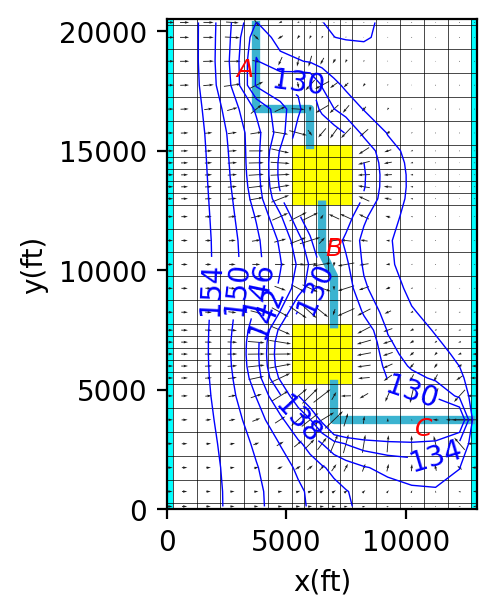

In [11]:
fig=plt.figure(figsize=(5, 7),dpi=200)              ; ax=fig.add_subplot(2, 2, 1, aspect="equal")     ; mm = flopy.plot.PlotMapView(gwf, ax=ax)
mm.plot_bc("CHD", color="cyan")                     ; mm.plot_inactive(color_noflow="yellow")         ; mm.plot_grid(lw=0.25, color="black")
cv=mm.contour_array(head,levels=np.arange(130, 155  , 4),linewidths=0.5,linestyles="-",colors="blue"  , masked_values=(0, 1e30, -1e30))  # countor
plt.clabel(cv, fmt="%1.0f")   
styles.add_text(ax ,"A" ,x=p1[0]+150 ,y=p1[1]+150 ,transform=False ,bold=False ,color="red" ,ha="left" ,va="bottom")
styles.add_text(ax ,"B" ,x=p2[0]+150 ,y=p2[1]+150 ,transform=False ,bold=False ,color="red" ,ha="left" ,va="bottom")
styles.add_text(ax ,"C" ,x=p3[0]+150 ,y=p3[1]+150 ,transform=False ,bold=False ,color="red" ,ha="left" ,va="bottom")

poly0 = [[xcenters[4], yedges[1]] ,[xcenters[4], ycenters[4]] ,[xcenters[7], ycenters[4]],[xcenters[7], yedges[6]]]                    # STR.shp
poly1 = [[xcenters[8], yedges[11]],[xcenters[8], yedges[13]]  ,[xcenters[9], yedges[14]] ,[xcenters[9], yedges[16]]]
poly2 = [[xcenters[9], yedges[21]],[xcenters[9], ycenters[22]],[xedges[16]  , ycenters[22]],]
parts = [poly0, poly1, poly2] ; shape_pth = os.path.join(sim_ws, "sfr.shp") ; w = shp.Writer(target=shape_pth, shapeType=shp.POLYLINE); 
w.field('no','C');w.line([poly0]);w.record(['1']);w.line([poly1]);w.record(['2']);w.line([poly2]);w.record(['3']) ;w.close()  ; sfr=shp.Reader(shape_pth)
for shape in sfr.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x, y, color="#3BB3D0", lw=3, zorder=1)

mm.plot_vector(qx, qy, normalize=False, color="0.1") ; ax.set_xlabel("x(ft)") ; ax.set_ylabel("y(ft)") ; plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

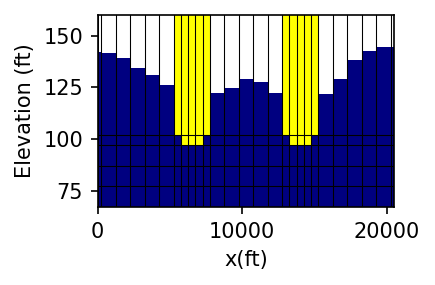

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2), dpi=150, tight_layout=True)    # surfaces 5 + (top) , Layers 5 (!) 
xs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"column": 8})               # Cross Section           

xs.plot_array(np.ones(shape3d), head=head, cmap="jet")  ; ax.set_xlabel("x(ft)") ; ax.set_ylim(67, 160)   ;  ax.set_ylabel("Elevation (ft)")
xs.plot_bc("CHD", color="cyan", head=head) ; xs.plot_ibound(color_noflow="yellow", head=head) ; xs.plot_grid(lw=0.5, color="black") ; plt.show

In [13]:
sim = build_models() ; gwf = sim.get_model(sim_name)  ; lak_res = gwf.lak.output.obs().data     ; gwf_res=gwf.obs[0].output.obs().data 

,LAKE1,LAKE2,A,B,C
time(days),,,,,
4.382077,122.542215,121.039522,115.245032,115.331696,115.232054
8.786065,119.548883,116.763520,115.501377,115.656249,115.454792
13.212072,118.115708,114.501414,115.771193,115.943355,115.667139
17.660209,117.355741,113.208742,116.056322,116.190429,115.869797
22.130588,116.925985,112.425833,116.358325,116.403762,116.064228


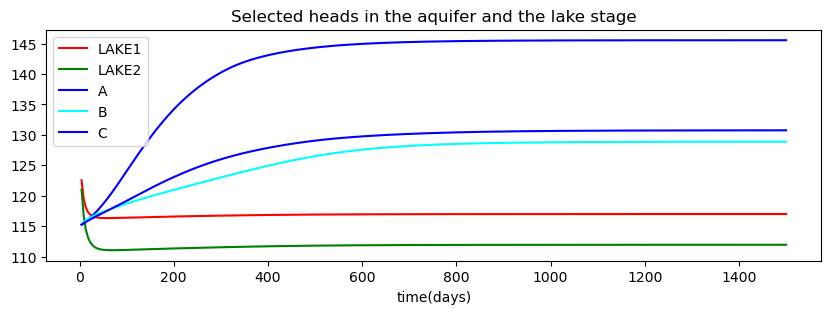

In [18]:
df1 = pd.DataFrame(lak_res) ; df2=pd.DataFrame(gwf_res)  ; df3 = df2.drop('totim', axis=1)   
df = pd.concat([df1[:], df3[:]], axis=1)  ; df.set_index('totim', inplace=True, drop=True) ; df.index.name = 'time(days)'  
ax = df.plot(use_index=True, y= list(df) , kind="line", rot=0, figsize=(10,3), 
             color=['red','green','blue','cyan','blue'], title='Selected heads in the aquifer and the lake stage') ; df.head() 

In [ ]:
(idomain_wlakes, pakdata_dict, lak_conn) = flopy.mf6.utils.get_lak_connections(gwf.modelgrid, lake_map, bedleak=lak_bedleak)
ab=pd.DataFrame(lak_conn) ; ab = ab.rename(columns = lambda x : 'a' + str(x))  ; ab2 = ab['a2']; ab3 = ab2.tolist()  
np.savetxt(output_folder / "07a_lak_conn_n.csv", ab3, delimiter=",")  
ab4=pd.DataFrame(ab3); ab5 = ab4.rename(columns = lambda x : 'b' + str(x))     ; df = pd.concat([ab[:], ab5[:]], axis=1)
df.to_csv (output_folder / "07b_lak_conn.csv") ; print('lak_conn ...β  from idomain_wlakes '); df.head() 

In [ ]:
(idomain_wlakes, pakdata_dict, lak_conn) = flopy.mf6.utils.get_lak_connections(gwf.modelgrid, lake_map, bedleak=lak_bedleak)
lak_packagedata = []  
for key in pakdata_dict.keys():  lak_packagedata.append([key, lak_strt, pakdata_dict[key]]); print('lak_packagedata',lak_packagedata)